<a href="https://colab.research.google.com/github/HSE-LAMBDA/MLDM-2022/blob/master/12-architectures/TL_AE_HW.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
%matplotlib inline
import time
import numpy as np
import pandas as pd
import datetime as dt
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import ImageGrid
from os import listdir, makedirs, getcwd, remove
from os.path import isfile, join, abspath, exists, isdir, expanduser
from PIL import Image
import torch
from torch.optim import lr_scheduler
from torch.autograd import Variable
from torch.utils.data import Dataset, DataLoader
import torchvision
from torchvision import transforms, datasets, models
from sklearn import svm, metrics

In [2]:
np.random.seed(1337)

# Dog Breed Identification




Download the dataset from [Dog Breed Identification
 Competition](https://www.kaggle.com/competitions/dog-breed-identification/data)

In [3]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
!pip install -U -q kaggle

In [4]:
!mkdir -p ~/.kaggle
!echo '{"username":"tianxiongyu","key":"594f6686ba2dc503e8dd8e1403343074"}' > ~/.kaggle/kaggle.json
!chmod 600 ~/.kaggle/kaggle.json

In [5]:
!kaggle --version

Kaggle API 1.5.12


In [6]:
!kaggle competitions list

ref                                             deadline             category            reward  teamCount  userHasEntered  
----------------------------------------------  -------------------  ---------------  ---------  ---------  --------------  
contradictory-my-dear-watson                    2030-07-01 23:59:00  Getting Started     Prizes         59           False  
gan-getting-started                             2030-07-01 23:59:00  Getting Started     Prizes         91           False  
store-sales-time-series-forecasting             2030-06-30 23:59:00  Getting Started  Knowledge        714           False  
tpu-getting-started                             2030-06-03 23:59:00  Getting Started  Knowledge        137           False  
digit-recognizer                                2030-01-01 00:00:00  Getting Started  Knowledge       1238           False  
titanic                                         2030-01-01 00:00:00  Getting Started  Knowledge      13960           False  


In [7]:
!kaggle competitions download -c dog-breed-identification

100% 688M/691M [00:30<00:00, 23.6MB/s]
100% 691M/691M [00:30<00:00, 23.5MB/s]


In [8]:
!unzip dog-breed-identification.zip -d data

流式输出内容被截断，只能显示最后 5000 行内容。
  inflating: data/train/83bc62b0fffa99a9c94ba0b67a5f7395.jpg  
  inflating: data/train/83bcff6b55ee179a7c123fa6103c377a.jpg  
  inflating: data/train/83be6d622ab74a5e7e08b53eb8fd566a.jpg  
  inflating: data/train/83c2d7419b0429b9fe953bc1b6cddbec.jpg  
  inflating: data/train/83cf7d7cd2a759a93e2ffd95bea9c6fb.jpg  
  inflating: data/train/83d405858f0931722ef21e8ac0adee4d.jpg  
  inflating: data/train/83d4125a4c3c7dc5956563276cb1cd74.jpg  
  inflating: data/train/83f0bb565b2186dbcc6a9d009cb26ff2.jpg  
  inflating: data/train/83fad0718581a696132c96c166472627.jpg  
  inflating: data/train/83fbbcc9a612e3f712b1ba199da61f20.jpg  
  inflating: data/train/8403d8936430c2f05ab7d74d23c2c0cb.jpg  
  inflating: data/train/8406d837b2d7fac1c3cd621abb4c4f9e.jpg  
  inflating: data/train/840b67d26e5e43f8eb6430f62d4ba1ac.jpg  
  inflating: data/train/840db91ba4600148f3dcb06ec419b421.jpg  
  inflating: data/train/840dbad5a691c22611d85b2488bf4cbb.jpg  
  inflating: data/train/8410

Let's use 64 most frequent breeds to simplify the task.

In [9]:
INPUT_SIZE = 224
NUM_CLASSES = 64
data_dir = '/content/data/'
labels = pd.read_csv(join(data_dir, 'labels.csv'))
sample_submission = pd.read_csv(join(data_dir, 'sample_submission.csv'))
print(len(listdir(join(data_dir, 'train'))), len(labels))
print(len(listdir(join(data_dir, 'test'))), len(sample_submission))

10222 10222
10357 10357


In [10]:
labels.head()

id             breed
0  000bec180eb18c7604dcecc8fe0dba07       boston_bull
1  001513dfcb2ffafc82cccf4d8bbaba97             dingo
2  001cdf01b096e06d78e9e5112d419397          pekinese
3  00214f311d5d2247d5dfe4fe24b2303d          bluetick
4  0021f9ceb3235effd7fcde7f7538ed62  golden_retriever

In [11]:
selected_breed_list = list(labels.groupby('breed').count().sort_values(by='id', ascending=False).head(NUM_CLASSES).index)
labels = labels[labels['breed'].isin(selected_breed_list)]
labels['target'] = 1
labels['rank'] = labels.groupby('breed').rank()['id']
labels_pivot = labels.pivot('id', 'breed', 'target').reset_index().fillna(0)

train = labels_pivot.sample(frac=0.8)
valid = labels_pivot[~labels_pivot['id'].isin(train['id'])]
print(train.shape, valid.shape) # train dataset and valid dataset

(4838, 65) (1210, 65)


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.


In [12]:
labels.head()

id               breed  target  rank
0  000bec180eb18c7604dcecc8fe0dba07         boston_bull       1   1.0
3  00214f311d5d2247d5dfe4fe24b2303d            bluetick       1   1.0
5  002211c81b498ef88e1b40b9abf84e1d  bedlington_terrier       1   1.0
6  00290d3e1fdd27226ba27a8ce248ce85  bedlington_terrier       1   2.0
8  003df8b8a8b05244b1d920bb6cf451f9             basenji       1   1.0

Custom dataset is going to be useful for our needs.

In [13]:
class DogsDataset(Dataset):
    def __init__(self, labels, root_dir, subset=False, transform=None):
        self.labels = labels
        self.root_dir = root_dir
        self.transform = transform
    
    def __len__(self):
        return len(self.labels)
    
    def __getitem__(self, idx):
        img_name = '{}.jpg'.format(self.labels.iloc[idx, 0])
        fullname = join(self.root_dir, img_name)
        image = Image.open(fullname)
        labels = self.labels.iloc[idx, 1:].to_numpy().astype('float')
        labels = np.argmax(labels)
        if self.transform:
            image = self.transform(image)
        return [image, labels]

In [21]:
normalize = transforms.Normalize(
   mean=[0.485, 0.456, 0.406],
   std=[0.229, 0.224, 0.225]
)
ds_trans = transforms.Compose([transforms.Resize(224),
                               transforms.CenterCrop(224),
                               transforms.ToTensor(),
                               normalize])
train_ds = DogsDataset(train, data_dir + 'train/', transform=ds_trans)
valid_ds = DogsDataset(valid, data_dir + 'train/', transform=ds_trans)

train_dl = DataLoader(train_ds, batch_size=4, shuffle=True, num_workers=4)
valid_dl = DataLoader(valid_ds, batch_size=4, shuffle=True, num_workers=4)

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:566: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


In [20]:
train_dl.dataset[0]

[tensor([[[ 0.4851,  0.4851,  0.5022,  ...,  0.4508,  0.4508,  0.4508],
          [ 0.3823,  0.3823,  0.3823,  ...,  0.3994,  0.4166,  0.4337],
          [ 0.4337,  0.4337,  0.4508,  ...,  0.3652,  0.3823,  0.3823],
          ...,
          [ 1.0159,  0.8961,  0.9303,  ..., -0.3198, -0.0801,  0.4337],
          [ 0.9817,  0.6906,  0.2282,  ..., -0.3198, -0.0458,  0.2624],
          [ 0.4508, -0.1657, -0.7137,  ...,  0.0741,  0.5193,  0.7933]],
 
         [[ 1.0455,  1.0455,  1.0630,  ...,  0.9930,  1.0105,  1.0105],
          [ 0.9405,  0.9405,  0.9405,  ...,  0.9230,  0.9405,  0.9755],
          [ 0.9755,  0.9755,  0.9755,  ...,  0.8880,  0.9055,  0.9055],
          ...,
          [ 0.9405,  0.7654,  0.7829,  ..., -0.3200, -0.0924,  0.3627],
          [ 0.9055,  0.5553,  0.0476,  ..., -0.3375, -0.0749,  0.2052],
          [ 0.3627, -0.3200, -0.9153,  ...,  0.0476,  0.5203,  0.7479]],
 
         [[ 1.0191,  1.0191,  1.0365,  ...,  1.0365,  1.0365,  1.0017],
          [ 0.9145,  0.9145,

In [22]:
def imshow(axis, inp):
    """Denormalize and show"""
    inp = inp.numpy().transpose((1, 2, 0))
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    inp = std * inp + mean
    axis.imshow(inp)

torch.Size([4, 3, 224, 224]) torch.Size([4])


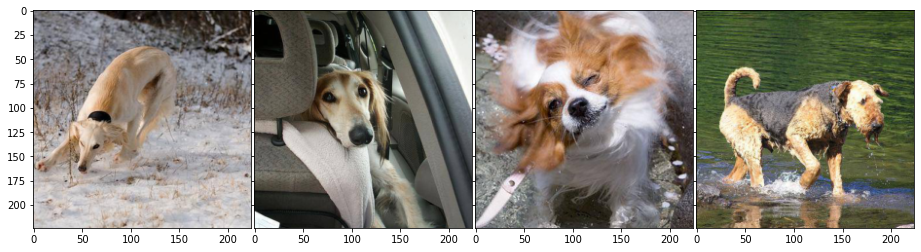

In [23]:
img, label = next(iter(train_dl))
print(img.size(), label.size())
fig = plt.figure(1, figsize=(16, 4))
grid = ImageGrid(fig, 111, nrows_ncols=(1, 4), axes_pad=0.05)    
for i in range(img.size()[0]):
    ax = grid[i]
    imshow(ax, img[i])

# Task 1: Transfer Learning (2 points)



Pick up some pretrained model, e.g. resnet 50 and tune it for our needs.

In [24]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
resnet = models.resnet50(pretrained=True)
inputs, labels = next(iter(train_dl))
resnet = resnet.to(device)
inputs, labels = inputs.to(device), labels.to(device)
outputs = resnet(inputs)
outputs.size()

/usr/local/lib/python3.7/dist-packages/torchvision/models/_utils.py:209: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and will be removed in 0.15, please use 'weights' instead.
  f"The parameter '{pretrained_param}' is deprecated since 0.13 and will be removed in 0.15, "
/usr/local/lib/python3.7/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and will be removed in 0.15. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnet50-0676ba61.pth" to /root/.cache/torch/hub/checkpoints/resnet50-0676ba61.pth


  0%|          | 0.00/97.8M [00:00<?, ?B/s]

torch.Size([4, 1000])

This models provides us with 1000 values, representing the classes which ResNet was trained on. 

Replace last layer with one that predicts the 64 classes. 
The network weights should be fixed expected for the last layer that is trained.

In [37]:
def train_model(dataloders,
                model,
                criterion,
                optimizer,
                scheduler,
                num_epochs=1):
    # Train the model and evaluate train and test accuracy
    # isn't the above indicates the vaild accuracy instead of test accuracy...?
    # Consider the sample_submission label is not given, only valid accuracy can be acquired.
    # YOUR CODE
    # inspired by https://www.kaggle.com/code/pvlima/use-pretrained-pytorch-models#ResNet50, the code is so damn good
    best_model = model.state_dict()
    best_acc = 0.0
    dataset_sizes = {'train': len(train_dl.dataset), 'valid': len(valid_dl.dataset)}

    for epoch in range(num_epochs): # here we have 1, adding this for general cases
        for phase in ['train', 'valid']:
            if phase == 'train':
                scheduler.step()
                model.train(True)
            else:
                model.train(False)

            running_loss = 0.0
            running_corrects = 0

            for inputs, labels in dataloders[phase]:
                if str(device) == "cuda":
                    inputs, labels = Variable(inputs.cuda()), Variable(labels.cuda())
                else:
                    inputs, labels = Variable(inputs), Variable(labels)

                optimizer.zero_grad()

                outputs = model(inputs)
                _, preds = torch.max(outputs.data, 1)
                loss = criterion(outputs, labels)

                if phase == 'train':
                    loss.backward()
                    optimizer.step()

                running_loss += loss.data
                running_corrects += torch.sum(preds == labels.data)
            
            if phase == 'train':
                train_epoch_loss = running_loss / dataset_sizes[phase]
                train_epoch_acc = running_corrects / dataset_sizes[phase]
            else:
                valid_epoch_loss = running_loss / dataset_sizes[phase]
                valid_epoch_acc = running_corrects / dataset_sizes[phase]
                
            if phase == 'valid' and valid_epoch_acc > best_acc:
                best_acc = valid_epoch_acc
                best_model = model.state_dict()

        print("Train accuracy {:4f}".format(train_epoch_acc))
        print("Valid accuracy {:4f}".format(valid_epoch_acc))
    model.load_state_dict(best_model)
    return model

In [38]:
resnet = models.resnet50(pretrained=True)
# freeze all model parameters
for param in resnet.parameters():
    param.requires_grad = False

# add new layer
# hint: you can get the number of features
# using in_features, e.g resnet.fc.in_features
num_fea = resnet.fc.in_features
resnet.fc = torch.nn.Linear(num_fea, 64)

resnet = resnet.cuda()

criterion = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(resnet.fc.parameters(), lr=0.001, momentum=0.9)
scheduler = lr_scheduler.StepLR(optimizer, step_size=7, gamma=0.1)

dloaders = {'train':train_dl, 'valid':valid_dl}

/usr/local/lib/python3.7/dist-packages/torchvision/models/_utils.py:209: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and will be removed in 0.15, please use 'weights' instead.
  f"The parameter '{pretrained_param}' is deprecated since 0.13 and will be removed in 0.15, "
/usr/local/lib/python3.7/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and will be removed in 0.15. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [ ]:
model = train_model(dloaders, resnet, criterion, optimizer, scheduler)

/usr/local/lib/python3.7/dist-packages/torch/optim/lr_scheduler.py:136: UserWarning: Detected call of `lr_scheduler.step()` before `optimizer.step()`. In PyTorch 1.1.0 and later, you should call them in the opposite order: `optimizer.step()` before `lr_scheduler.step()`.  Failure to do this will result in PyTorch skipping the first value of the learning rate schedule. See more details at https://pytorch.org/docs/stable/optim.html#how-to-adjust-learning-rate
  "https://pytorch.org/docs/stable/optim.html#how-to-adjust-learning-rate", UserWarning)


Train accuracy 0.409673
Valid accuracy 0.812397


In [39]:
def visualize_model(dataloders, model, num_images=16):
    cnt = 0
    fig = plt.figure(1, figsize=(16, 16))
    grid = ImageGrid(fig, 111, nrows_ncols=(4, 4), axes_pad=0.05)
    for i, (inputs, labels) in enumerate(dataloders['valid']):
        inputs, labels = inputs.to(device), labels.to(device)
        outputs = model(inputs)
        _, preds = torch.max(outputs.data, 1)

        for j in range(inputs.size()[0]):
            ax = grid[cnt]
            imshow(ax, inputs.cpu().data[j])
            ax.text(10, 210, ' Prediction: {}\n Real Label: {}'.format(preds[j], labels.data[j]), 
                    color='k', backgroundcolor='w', alpha=0.8)
            cnt += 1
            if cnt == num_images:
                return

In [ ]:
visualize_model(dloaders, model)

# Task 2: Low-dimensional dogs (4 points)
Train a **Conditional CNN Autoencoder** that takes class labels into account. Show examples of interpolations between instances of different classes in a latent space and related representation of images in original space (just the same way we did it during practical session). 

In [40]:
import random
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torch.utils.data as data
from torch.utils.data import TensorDataset, DataLoader
from torchvision import datasets, transforms
from mpl_toolkits.axes_grid1 import AxesGrid
random.seed(2337)
torch.manual_seed(2337)

#### Define autoencoder

In [212]:
class AutoEncoder(nn.Module):
    
    def __init__(self, dim_input, dim_hidden):
        super().__init__()
        self.encoder = nn.Sequential(
            nn.Conv2d(in_channels=dim_input, out_channels=32, kernel_size=3),
            nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3),
            nn.Conv2d(in_channels=64, out_channels=dim_hidden, kernel_size=3),
            nn.Sigmoid()
            )
        self.decoder = nn.Sequential(
            nn.ConvTranspose2d(in_channels=dim_hidden, out_channels=64, kernel_size=3),
            nn.ConvTranspose2d(in_channels=64, out_channels=32, kernel_size=3),
            nn.ConvTranspose2d(in_channels=32, out_channels=dim_input, kernel_size=3),
            nn.Sigmoid()
            )
        
    def forward(self, x):
        h = self.encoder(x)
        x_ = self.decoder(h)
        return x_

AutoEncoder(
  (encoder): Sequential(
    (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1))
    (1): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1))
    (2): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1))
    (3): Sigmoid()
  )
  (decoder): Sequential(
    (0): ConvTranspose2d(128, 64, kernel_size=(3, 3), stride=(1, 1))
    (1): ConvTranspose2d(64, 32, kernel_size=(3, 3), stride=(1, 1))
    (2): ConvTranspose2d(32, 3, kernel_size=(3, 3), stride=(1, 1))
    (3): Sigmoid()
  )
)


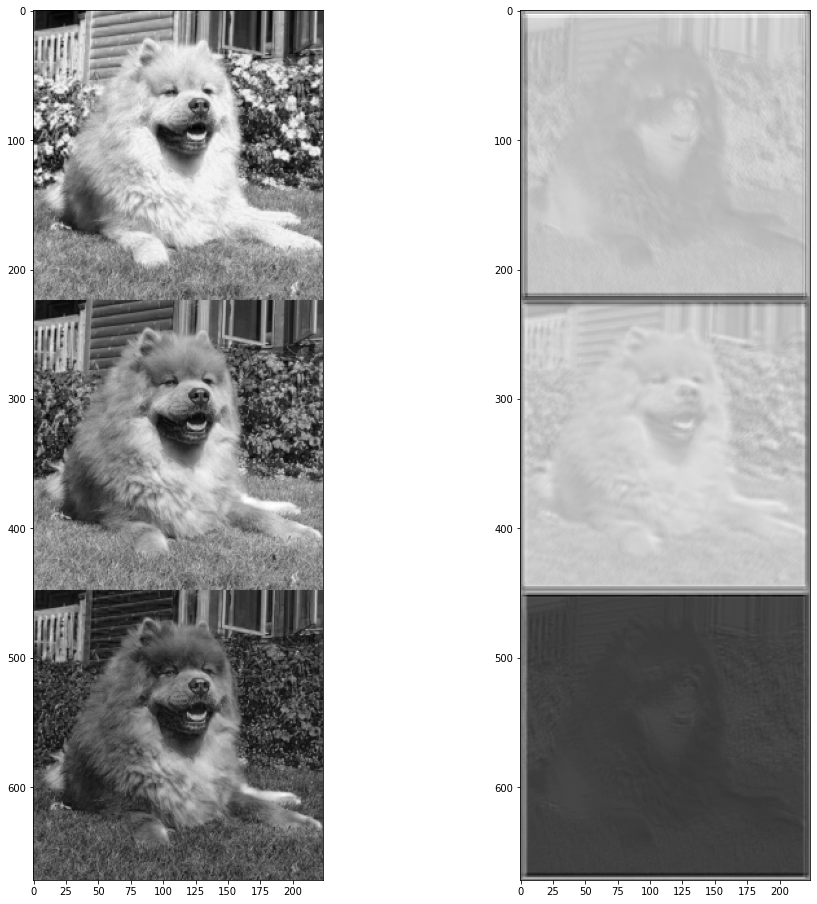

In [217]:
dim_hidden = 128
net_ae = AutoEncoder(3, dim_hidden)
print(net_ae)

# propagate a sample
x = train_dl.dataset[i][0].view(-1, 3, 224, 224) # the original input, as an example
x_ = net_ae(x)

# show the result
plt.figure(figsize=(16, 16))
plt.subplot(1, 2, 1)
plt.imshow(x.view(224*3, 224).numpy(), cmap="gray")
plt.subplot(1, 2, 2)
plt.imshow(x_.view(224*3, 224).detach().numpy(), cmap="gray")
plt.show()

AutoEncoder(
  (encoder): Sequential(
    (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1))
    (1): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1))
    (2): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1))
    (3): Sigmoid()
  )
  (decoder): Sequential(
    (0): ConvTranspose2d(128, 64, kernel_size=(3, 3), stride=(1, 1))
    (1): ConvTranspose2d(64, 32, kernel_size=(3, 3), stride=(1, 1))
    (2): ConvTranspose2d(32, 3, kernel_size=(3, 3), stride=(1, 1))
    (3): Sigmoid()
  )
)


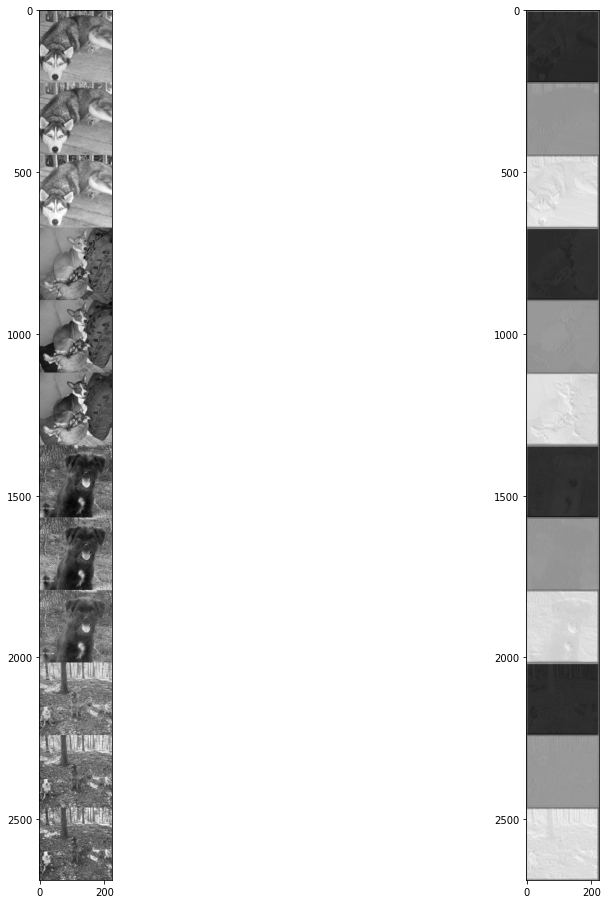

In [218]:
dim_hidden = 128
net_ae = AutoEncoder(3, dim_hidden)
print(net_ae)

# propagate another sample
x = next(iter(train_dl))[0].view(-1, 3, 224, 224) # the original input, batch=4
x_ = net_ae(x)

# show the result
plt.figure(figsize=(16, 16))
plt.subplot(1, 2, 1)
plt.imshow(x.view(224*12, 224).numpy(), cmap="gray")
plt.subplot(1, 2, 2)
plt.imshow(x_.view(224*12, 224).detach().numpy(), cmap="gray")
plt.show()

#### Training cnn autoencoder

In [169]:
def train_epoch(net, loader, optimizer, criterion, device): 
    net.train()
    loss_avg = 0
    for x, _ in loader:
        # construct a batch
        x = x.view(-1, 3, 224, 224).to(device)

        # zero the gradients
        optimizer.zero_grad()

        # forward propagation
        x_ = net(x)

        # compute the loss
        loss = criterion(x_, x)

        # backward propagation
        loss.backward()

        # update the weights
        optimizer.step()

        loss_avg += loss.item()
    loss_avg = loss_avg / len(loader)
    return loss_avg

In [170]:
def test_epoch(net, loader, criterion, device): 
    net.eval()
    loss_avg = 0
    for x, _ in loader:
        # construct a batch
        x = x.view(-1, 3, 224, 224).to(device)

        # forward propagation
        x_ = net(x)

        # compute the loss
        loss = criterion(x_, x)

        loss_avg += loss.item()
    loss_avg = loss_avg / len(loader)
    return loss_avg

In [171]:
def train(net, train_loader, test_loader, optimizer, epochs, criterion, device): 
    train_losses = np.zeros((epochs))
    test_losses = np.zeros((epochs))
    for epoch in range(epochs):
        train_losses[epoch] = train_epoch(net, train_loader, optimizer, criterion, device)
        test_losses[epoch] = test_epoch(net, test_loader, criterion, device)
        print("Epoch %d/%d: Train loss = %.4f - Test loss = %.4f" 
              % (epoch + 1, epochs, train_losses[epoch], test_losses[epoch]))
    
    return train_losses, test_losses

In [224]:
lr = 1e-2
weight_decay = 1e-5
epochs = 3
net_ae = net_ae.to(device)

# optimizer = torch.optim.SGD(net_ae.parameters(), lr=lr, momentum=0.9)
optimizer = optim.Adam(net_ae.parameters(), lr=lr, weight_decay=weight_decay)
# criterion = torch.nn.CrossEntropyLoss()
criterion = nn.MSELoss()

In [ ]:
# without taking labels into account, the model constructed just okey
train_loss, test_loss = train(net_ae, train_dl, valid_dl, 
                              optimizer, epochs, criterion, device) 

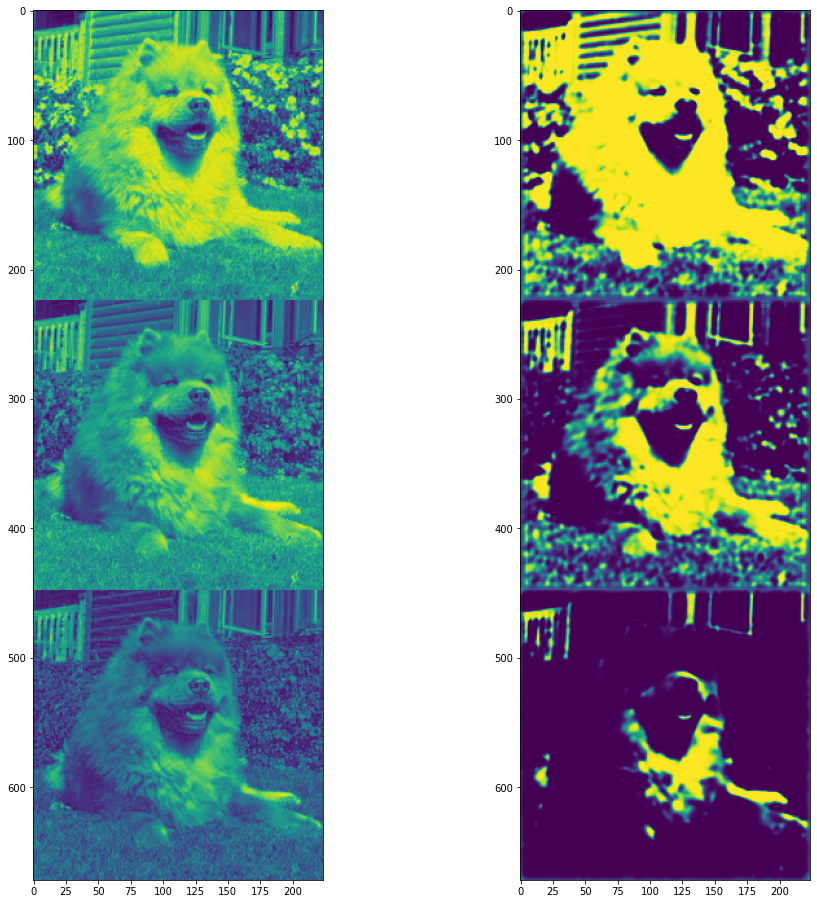

In [221]:
# propagate a sample
net_ae.eval()
x = train_dl.dataset[i][0].view(-1, 3, 224, 224).to(device)
x_ = net_ae(x)
# show the result
plt.figure(figsize=(16, 16))
plt.subplot(1, 2, 1)
plt.imshow(x.view(224*3, 224).cpu().numpy())
plt.subplot(1, 2, 2)
plt.imshow(x_.view(224*3, 224).cpu().detach().numpy())
plt.show()


#### Latent Space Interpolation

In [1]:
# pick two examples from the dataset
a = valid_dl.dataset[i][0].view(-1, 3, 224, 224)
b = valid_dl.dataset[i+1][0].view(-1, 3, 224, 224)

# build a grid
fig = plt.figure(figsize=(60,5))
grid = AxesGrid(fig, 141, nrows_ncols=(1, 11),
                axes_pad=0.00, label_mode="1")

# interpolate between images
for k in range(11):
    z = k/10. * a + (1. - k/10.) * b
    im = grid[k].imshow(z.view(224*3, 224).numpy(), interpolation="nearest")

NameError: ignored

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:4: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  after removing the cwd from sys.path.


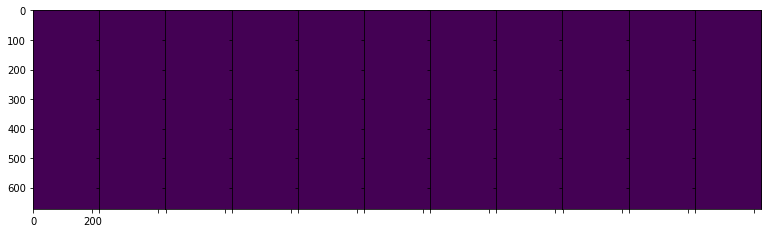

In [211]:
# get low-dimentional representations
x = torch.tensor(a.view(-1, 3, 224, 224)).to(device)
a_emb = net_ae.encoder(x)   
x = torch.tensor(b.view(-1, 3, 224, 224)).to(device)
b_emb = net_ae.encoder(x) 

fig = plt.figure(figsize=(60,5))
grid = AxesGrid(fig, 141, nrows_ncols=(1, 11),
                axes_pad=0.00, label_mode="1",)

for k in range(11):
    # interpolate in latent space
    z_emb = k/10. * a_emb + (1. - k/10.) * b_emb
    # use the latent code to decode the results
    z = net_ae.decoder(z_emb)
    im = grid[k].imshow(z.cpu().data.numpy().reshape(224*3, 224), interpolation="nearest")

In [ ]:
def compute_embeddings(net, loader):
    net.eval()
    embeddings = np.zeros(((dim_hidden * len(loader.dataset), 3, 1))) #quite problmatic, no idea of its proper shape
    b = 0
    for x, _ in loader:
        x = x.view(3, -1, 224)
        h = net.encoder(x).cpu().detach().numpy()
        embeddings[b: b+len(h)] = h
        b += len(h)
    return embeddings

In [ ]:
h_train = compute_embeddings(net_ae, train_dl)

ValueError: ignored

In [ ]:
# take class labels into account?
def train_svm(x_train, y_train, n):
    clf = svm.SVC()
    clf.fit(x_train[:n], y_train[:n])
    return clf

def test_svm(clf, x_test, y_test):
    predicted = clf.predict(x_test)
    acc = metrics.accuracy_score(y_test, predicted)
    return acc
  

In [ ]:
# compute the embeddings of the autoencoder on the train and test set
h_train = compute_embeddings(net_ae, train_dl)
h_test = compute_embeddings(net_ae, valid_dl)

# train and test an SVM for a varying amount of training data
n_train_min = 10
n_train_max = 200
n_train_step = 10
n_samples = np.arange(n_train_min, n_train_max, n_train_step)
accuracies_ae = np.zeros((len(n_samples)))
accuracies_bl = np.zeros((len(n_samples)))
for j in range(len(n_samples)):
    # autoencoder
    clf = train_svm(h_train, train_dl.dataset.targets.numpy(), n_samples[j])
    accuracies_ae[j] = test_svm(clf, h_test, valid_dl.dataset.targets.numpy())
    # baseline
    clf = train_svm(train_dl.dataset.data.numpy().reshape((56*56, -1, 4)), 
                    train_dl.dataset.targets.numpy(), n_samples[j])
    accuracies_bl[j] = test_svm(clf, valid_dl.dataset.data.numpy().reshape((56*56, -1, 4)), 
                                valid_dl.dataset.targets.numpy())

AttributeError: ignored

# Task 3: Boosting the quality (2 points)

The general objective here is to boost the quality you got on the first step. 
You can tune one/two more models from `torchvision` or `timm` and stack their predictions **OR** create your own CNN and use the encoder of your Autoencoder from 2nd task **OR** both. 

Don't forget to compare your models properly, e.g. it's not enough to run them for only a few epochs.

Write a comment on model comparison, things and ideas that helped boost the quality, and anything else you would like to share. 